# Seattle Airbnb prices time series analysis

This notebook explores the Seattle Airbnb calendar data to provide insights into when, where and what type of booking is best.

This analysis seeks to answer the following:<br>
1. How do prices fluctuate throughout the year ?
2. How does this fluctuaion vary across neighbourhoods and property types ?
3. How does availalbility vary across the year ?    

All data used here is sourced from : https://www.kaggle.com/datasets/airbnb/seattle?select=listings.csv

Data used :
1. listing.csv - database of individual listings with description, reviews and other attributes.
2. calender.csv - database of bookings available and their respective prices.

# Data Import

In [1]:
#Importing necessary packages
import pandas as pd
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

In [2]:
#Importing data
calendar_df = pd.read_csv("data/calendar.csv")
listings_df = pd.read_csv("data/listings.csv")

In [3]:
# Have a look at column datatypes
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


# Data preparation

In [5]:
#coverting date to datetime datatype
calendar_df['date'] = pd.to_datetime(calendar_df['date'], format='%Y-%m-%d')

#Getting month from date
calendar_df['month']=calendar_df['date'].dt.strftime('%b')

#Getting day of the week from date
calendar_df['dayOfWeek']=calendar_df['date'].dt.day_name()

In [6]:
#Cleaning and converting price to float
price_clean = lambda col: float(str(col).replace('$','').replace(',',''))
calendar_df['price_cleaned']= calendar_df['price'].apply(price_clean)
calendar_df.head(2)

,listing_id,date,available,price,month,dayOfWeek,price_cleaned
0,241032,2016-01-04,t,$85.00,Jan,Monday,85.0
1,241032,2016-01-05,t,$85.00,Jan,Tuesday,85.0


In [7]:
#Transform availability column for easy computation later

print('Before transfomation')
print(calendar_df.groupby(['available'])['available'].count(),"\n\n")

calendar_df.loc[calendar_df['available'] == 'f', 'available'] = 0
calendar_df.loc[calendar_df['available'] == 't', 'available'] = 1

print('After transfomation')
print(calendar_df.groupby(['available'])['available'].count())

Before transfomation
available
f    459028
t    934542
Name: available, dtype: int64 


After transfomation
available
0    459028
1    934542
Name: available, dtype: int64


In [8]:
#calendar_df data is for year looking forward from 4Jan16, the date when the dataset was created. 
#Price is missing for bookings already made, i.e marked as unavailaible in this calendar_df df
calendar_df[calendar_df['price_cleaned'].isnull()]\
.groupby(['available'])['available'].count()

available
0    459028
Name: available, dtype: int64

In [9]:
#Selecting id and price form listings df and renaming columns
listings_price = pd.DataFrame(listings_df[['id','price']])
listings_price.rename(columns = {'id':'listing_id', 'price':'listing_price'}, inplace = True)

#Cleaning price column and converting to float
listings_price['listing_price']= listings_price['listing_price'].apply(price_clean)

#Adding price from listings table to calendar_df df. Printing shape before and after join
print("Number of rows before join :",calendar_df.shape[0])
calendar_df_cleaned = pd.merge(calendar_df, listings_price, how="left", on=['listing_id'])
print("Number of rows after join :",calendar_df_cleaned.shape[0])

#Replace missing vlaues in price_cleaned with listing_price
calendar_df_cleaned['price_cleaned'].fillna(calendar_df_cleaned['listing_price'],inplace=True)

Number of rows before join : 1393570
Number of rows after join : 1393570


In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns

### How do prices fluctuate throughout the year ?

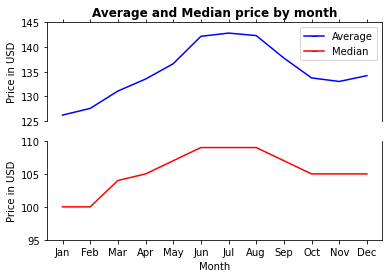

In [13]:
#Plotting average and median price across months 
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
sns.lineplot(x='month',y='price_cleaned',\
             data=calendar_df_cleaned,estimator='mean',ci=None,ax=ax,color='b')

sns.lineplot(x='month',y='price_cleaned',\
             data=calendar_df_cleaned,ci=None,estimator='median',ax=ax2,color='r')

#Setting plot title and axes labels
ax.set_title('Average and Median price by month', 
   fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax2.set_xlabel('Month')
ax.set_ylabel('Price in USD')
ax2.set_ylabel('Price in USD')

#Custom legend
ax.legend(handles=[Line2D([], [], marker='_', color="b", label='Average'),\
                Line2D([], [], marker='_', color="r", label='Median')])

#Limit y axes limits across both plots to remove whitespace
ax.set(ylim=(125, 145))
ax2.set(ylim=(95, 110))

#Format to remove top and bottom spines of the two plots to create the illusion of a broken y axis
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

plt.savefig('visualizations/mean_median_prices_bymonth.png');

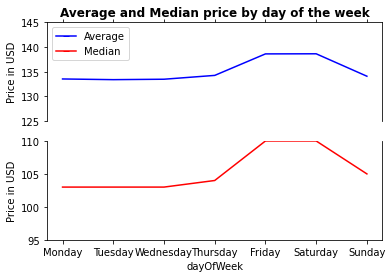

In [14]:
#Plotting average and median price across days of the week
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
sns.lineplot(x='dayOfWeek',y='price_cleaned',\
             data=calendar_df_cleaned,estimator='mean',ci=None,ax=ax,color='b')

sns.lineplot(x='dayOfWeek',y='price_cleaned',\
             data=calendar_df_cleaned,ci=None,estimator='median',ax=ax2,color='r')

#Setting plot title and axes labels
ax.set_title('Average and Median price by day of the week', 
   fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Price in USD')
ax2.set_ylabel('Price in USD')

#Custom legend
ax.legend(handles=[Line2D([], [], marker='_', color="b", label='Average'),\
                Line2D([], [], marker='_', color="r", label='Median')])

#Limit y axes limits across both plots to remove whitespace
ax.set(ylim=(125, 145))
ax2.set(ylim=(95, 110))

#Format to remove top and bottom spines of the two plots to create the illusion of a broken y axis
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
plt.savefig('visualizations/mean_median_prices_byday.png');

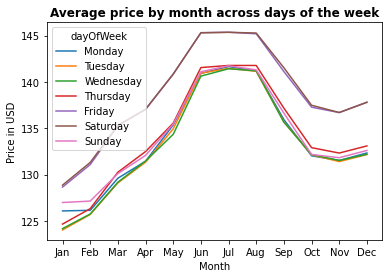

In [15]:
#Plotting average price by month for each day of the week
ax=sns.lineplot(x='month',y='price_cleaned',hue='dayOfWeek',\
             data=calendar_df_cleaned,estimator='mean',ci=None )

ax.set_title('Average price by month across days of the week', 
   fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('Price in USD')
plt.savefig('visualizations/mean_prices_byMonth_forEachDay.png');

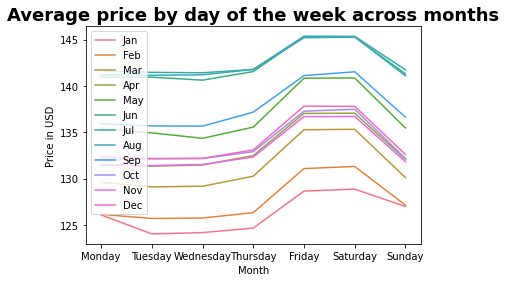

In [16]:
#Plotting average price by day of the week for each month
ax=sns.lineplot(x='dayOfWeek',y='price_cleaned',hue='month',\
             data=calendar_df_cleaned,estimator='mean',ci=None )

ax.set_title('Average price by day of the week across months', 
   fontdict={'size': 18, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('Price in USD')
plt.legend(loc='upper left')
plt.savefig('visualizations/mean_prices_byDayOfWeek_forEachMonth.png');

### How does the price fluctuaion vary across neighbourhoods and property types ?

In [17]:
#Filtering Listings df for features of interest
listings_featues_to_consider = ['neighbourhood_group_cleansed','property_type',\
                  'room_type','bed_type']
listings_features = pd.DataFrame(listings_df[['id']+listings_featues_to_consider])
listings_features.rename(columns = {'id':'listing_id'}, inplace = True)


#Adding listing attributes to calendar_df_cleaned. Printing shape before and after join
print("Number of rows before join :",calendar_df_cleaned.shape[0])
calendar_df_cleaned = pd.merge(calendar_df_cleaned, listings_features, how="left", on=['listing_id'])
print("Number of rows after join :",calendar_df_cleaned.shape[0])

calendar_df_cleaned.head(2)

Number of rows before join : 1393570
Number of rows after join : 1393570


,listing_id,date,available,price,month,dayOfWeek,price_cleaned,listing_price,neighbourhood_group_cleansed,property_type,room_type,bed_type
0,241032,2016-01-04,1,$85.00,Jan,Monday,85.0,85.0,Queen Anne,Apartment,Entire home/apt,Real Bed
1,241032,2016-01-05,1,$85.00,Jan,Tuesday,85.0,85.0,Queen Anne,Apartment,Entire home/apt,Real Bed


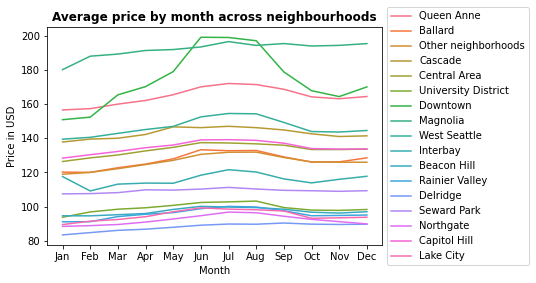

In [18]:
#Plotting average price by month for each neighbourhood
ax=sns.lineplot(x='month',y='price_cleaned',hue='neighbourhood_group_cleansed',\
             data=calendar_df_cleaned,estimator='mean',ci=None )
ax.set_title(f'Average price by month across neighbourhoods', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('Price in USD')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('visualizations/mean_prices_byMonth_forEachNeighbourhood.png');

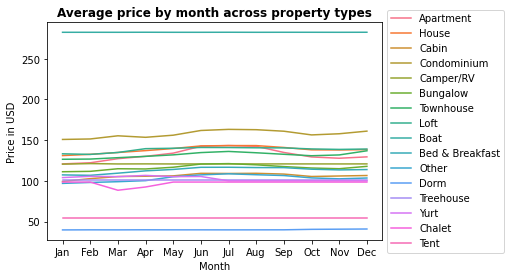

In [19]:
#Plotting average price by month for each property_type
ax=sns.lineplot(x='month',y='price_cleaned',hue='property_type',\
             data=calendar_df_cleaned,estimator='mean',ci=None )
ax.set_title(f'Average price by month across property types', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('Price in USD')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('visualizations/mean_prices_byMonth_forEachPropertyType.png');

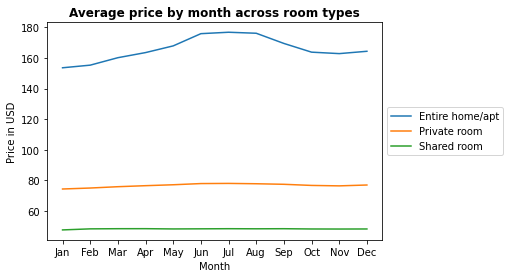

In [20]:
#Plotting average price by month for each room_type
ax=sns.lineplot(x='month',y='price_cleaned',hue='room_type',\
             data=calendar_df_cleaned,estimator='mean',ci=None )
ax.set_title(f'Average price by month across room types', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('Price in USD')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('visualizations/mean_prices_byMonth_forEachRoomType.png');

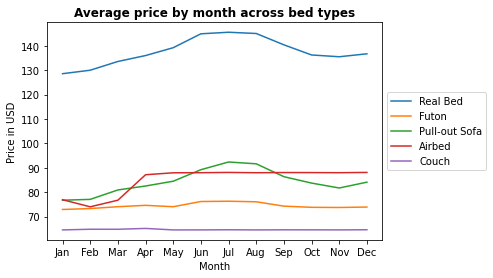

In [21]:
#Plotting average price by month for each bed_type
ax=sns.lineplot(x='month',y='price_cleaned',hue='bed_type',\
             data=calendar_df_cleaned,estimator='mean',ci=None )
ax.set_title(f'Average price by month across bed types', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('Price in USD')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('visualizations/mean_prices_byMonth_forEachBedType.png');

### How does availalbility vary across the year ? 

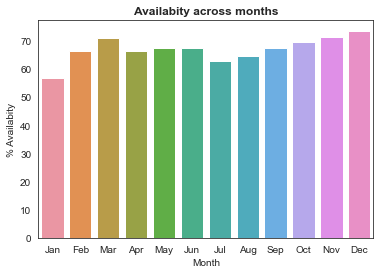

In [162]:
#Plotting availability across months
ax=sns.barplot(x='month', y='available', data=calendar_df_cleaned, estimator=lambda x: sum(x==1)*100.0/len(x),ci=None)
ax.set_title(f'Availabity across months', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('% Availabity');
plt.savefig('visualizations/availability_byMonth.png');

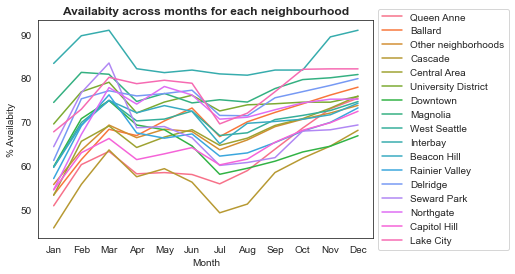

In [164]:
#Plotting availability across months by neighbourhood
ax=sns.lineplot(x='month', y='available', hue='neighbourhood_group_cleansed',\
               data=calendar_df_cleaned, estimator=lambda x: sum(x==1)*100.0/len(x),ci=None)
ax.set_title(f'Availabity across months for each neighbourhood', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('% Availabity')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('visualizations/availability_byMonth_forEachNeighbourhood.png');

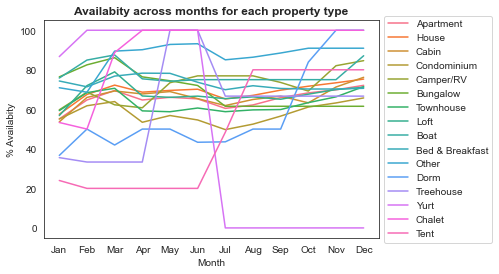

In [165]:
#Plotting availability across months by property types
ax=sns.lineplot(x='month', y='available', hue='property_type',\
               data=calendar_df_cleaned, estimator=lambda x: sum(x==1)*100.0/len(x),ci=None)
ax.set_title(f'Availabity across months for each property type', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('% Availabity')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('visualizations/availability_byMonth_forEachPropertyType.png');

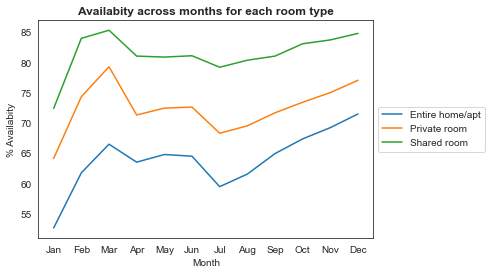

In [168]:
#Plotting availability across months by neighbourhood
ax=sns.lineplot(x='month', y='available', hue='room_type',\
               data=calendar_df_cleaned, estimator=lambda x: sum(x==1)*100.0/len(x),ci=None)
ax.set_title(f'Availabity across months for each room type', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('% Availabity')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('visualizations/availability_byMonth_forEachRoomType.png');

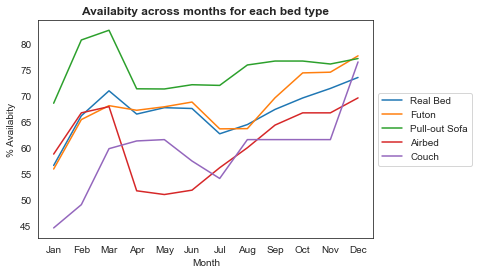

In [169]:
#Plotting availability across months by neighbourhood
ax=sns.lineplot(x='month', y='available', hue='bed_type',\
               data=calendar_df_cleaned, estimator=lambda x: sum(x==1)*100.0/len(x),ci=None)
ax.set_title(f'Availabity across months for each bed type', 
fontdict={'size': 12, 'weight': 'bold'})
ax.set_xlabel('Month')
ax.set_ylabel('% Availabity')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('visualizations/availability_byMonth_forEachBedType.png');
# 'neighbourhood_group_cleansed','property_type',\
#                   'room_type','bed_type'